<img src="https://github.com/rjpost20/vanguard_de_project_Ryan_Posternak/blob/main/images/pexels-vishnu-r-nair-1105666.jpg?raw=true">
Image by <a href="https://www.pexels.com/@vishnurnair/" >Vishnu R Nair</a> on <a href="https://www.pexels.com/photo/people-at-concert-1105666/" >Pexels.com</a>

# *Onramp x Vanguard Spotify Project*

## Notebook 3: Analytics and Visualizations

## *By Ryan Posternak*

<br>

## Table of Contents:

* Step 1: Data Ingestion
 * Establish Connection to Spotify's API
 * Part 1: Artists Dataframe
 * Part 2: Albums Dataframe
 * Part 3: Tracks Dataframe
 * Part 4: Track Features Dataframe
<br><br>
* Step 2: Data Transformation
 * Part 1: Handling Null/Missing Values
 * Part 2: Deduplication
   * 2.1: Remove duplicate albums
   * 2.2: Remove duplicate songs
<br><br>
* Step 3: Storage
 * Part 1: artist Table
 * Part 2: album Table
 * Part 3: track Table
 * Part 4: track_feature Table
<br><br>
* __Step 4: Analytics / Visualizations__
 * __Part 1: SQL Query Analytics__
   * __1.1: Top songs by artist in terms of `duration_ms`__
   * __1.2: Top artists in the database by number of `followers`__
   * __1.3: Top songs by artist in terms of `tempo`__
   * __1.4: Average `track_feature` values by artist__
   * __1.5: Max and min average `track_feature` and `duration_ms` values by album__
   * __1.6: Proportion of `explicit` tracks by artist__
   * __1.7: Median `track_feature` values by artist__
 * __Part 2: Data Visualizations__
   * __2.1: Mean `track_feature` values by `genre`__
   * __2.2: Distribution of `track_feature` and `duration_ms` values__
   * __2.3: Evolution of artists, visualized__
   * __2.4: Evolution of genres, visualized__
   * __2.5: Correlations between `track_feature` + `duration_ms` + `followers` values__

## Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os

import sqlite3
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%matplotlib inline

<br>

# Step 4: Analytics / Visualizations

### Import pandas `pkl` files

In [2]:
artists_df = pd.read_pickle('data/artists_df.pkl')

albums_df = pd.read_pickle('data/albums_df.pkl')

tracks_df = pd.read_pickle('data/tracks_df.pkl')

track_features_df = pd.read_pickle('data/track_features_df.pkl')

### Connect to `spotify.db`

In [3]:
# Establish connection to SQLite server and spotify.db file
conn = sqlite3.Connection("data/spotify.db")
c = conn.cursor()

<br>

## Part 1: SQL Query Analytics

### 1.1: Top 10 songs by artist in terms of `duration_ms`

Below I run a query on the top 10 songs by each artist in terms of `duration_ms` and order them by `artist_name` (ascending) and `duration_mins` (descending), making sure to keep the artist's songs together for improved readability and interpretability. I also convert the duration from milliseconds to minutes (as a floating point number with two decimals) — again for improved interpretability.

In [4]:
q1 = """
SELECT artist_name,
song_name,
album_name,
-- Convert duration column from ms to mins
ROUND((duration_ms / 1000.0 / 60), 2) AS duration_mins
FROM (
    SELECT track_id,
    artist_name,
    song_name,
    album_name,
    duration_ms,
--  Create rank of top songs by artist in terms of duration_ms */
    ROW_NUMBER() OVER 
        (PARTITION BY artist_id ORDER BY duration_ms DESC) AS duration_rank
    FROM track
        JOIN album
            USING(album_id)
        JOIN artist
            USING(artist_id))
-- Display 10 songs per artist
WHERE duration_rank <= 10
ORDER BY artist_name, duration_mins DESC;
"""

pd.read_sql(q1, conn)

,artist_name,song_name,album_name,duration_mins
0,Beyoncé,Drunk in Love Remix (feat. Jay-Z & Kanye West),BEYONCÉ [Platinum Edition],6.60
1,Beyoncé,Rocket,BEYONCÉ [Platinum Edition],6.53
2,Beyoncé,Get Me Bodied - Extended Mix,B'Day Deluxe Edition,6.32
3,Beyoncé,Mine (feat. Drake),BEYONCÉ [Platinum Edition],6.31
4,Beyoncé,Dance for You,4,6.29
...,...,...,...,...
195,blackbear,idfc,deadroses,4.09
196,blackbear,I feel 2 much,everything means nothing,4.00
197,blackbear,broken world,in loving memory,3.82
198,blackbear,bright pink tims (feat. Cam'ron),cybersex,3.81


In [5]:
c.execute("""CREATE VIEW IF NOT EXISTS q1_top_songs_by_artist_duration
AS """ + q1)

<br>

### 1.2: Top 20 artists in the database by number of `followers`

Here I display the name, genre, and follower count of all the artists in the database by number of followers (descending). For improved readability, I add comma separators to the follower counts as the numbers are quite large. In order to drop the unformatted `followers` column I wrap the initial query in a subquery.

In [6]:
q2 = """
SELECT artist_name, genre, followers
FROM (
--  Create new followers column by adding commas to original unformatted followers column
    SELECT artist_name, genre, followers AS followers_count, FORMAT("%,d", followers) AS followers
    FROM artist
    ORDER BY followers_count DESC);
"""

pd.read_sql(q2, conn)

,artist_name,genre,followers
0,Billie Eilish,art pop,"68,972,660"
1,Drake,canadian hip hop,"67,153,280"
2,The Weeknd,canadian contemporary r&b,"49,892,438"
3,Post Malone,dfw rap,"38,200,403"
4,Beyoncé,dance pop,"32,184,686"
5,The Beatles,beatlesque,"23,589,724"
6,Doja Cat,dance pop,"21,994,159"
7,The Chainsmokers,dance pop,"19,476,156"
8,J. Cole,conscious hip hop,"17,923,010"
9,Pink Floyd,album rock,"17,537,356"


In [7]:
c.execute("""CREATE VIEW IF NOT EXISTS q2_top_songs_by_followers
AS """ + q2)

<br>

### 1.3: Top 10 songs by artist in terms of `tempo`

Below is a similar query to the first, but replacing `duration_ms` with `tempo`. It's a query of the top 10 songs by artist in terms of `tempo`.

In [8]:
q3 = """
SELECT artist_name,
song_name,
album_name,
tempo
FROM (
    SELECT track_id,
    artist_name,
    song_name,
    album_name,
    tempo,
--  Create rank of top songs by artist in terms of duration_ms
    ROW_NUMBER() OVER 
        (PARTITION BY artist_id ORDER BY tempo DESC) AS tempo_rank
    FROM track
        JOIN album
            USING(album_id)
        JOIN artist
            USING(artist_id)
        JOIN track_feature
            USING(track_id))
-- Display 10 songs per artist
WHERE tempo_rank <= 10
ORDER BY artist_name, tempo DESC;
"""

pd.read_sql(q3, conn)

,artist_name,song_name,album_name,tempo
0,Beyoncé,Resentment,B'Day Deluxe Edition,197.431
1,Beyoncé,Single Ladies (Put a Ring on It),I AM...SASHA FIERCE,193.437
2,Beyoncé,Irreplaceable (Irreemplazable) - Nortena Remix,B'Day Deluxe Edition,176.042
3,Beyoncé,Partition,BEYONCÉ [Platinum Edition],175.928
4,Beyoncé,Irreplaceable,B'Day Deluxe Edition,175.868
...,...,...,...,...
195,blackbear,dead inside,in loving memory,148.042
196,blackbear,DOWN,ANONYMOUS,148.027
197,blackbear,idfc,deadroses,144.871
198,blackbear,ain't trippin,deadroses,144.069


In [9]:
c.execute("""CREATE VIEW IF NOT EXISTS q3_top_songs_by_artist_tempo
AS """ + q3)

<br>

### 1.4: Average `track_feature` values by artist

In [10]:
q4 = """
SELECT artist_name,
AVG(danceability),
AVG(energy),
AVG(instrumentalness),
AVG(liveness),
AVG(loudness),
AVG(speechiness),
AVG(tempo),
AVG(valence)
FROM track
    JOIN album
        USING(album_id)
    JOIN artist
        USING(artist_id)
    JOIN track_feature
        USING(track_id)
GROUP BY artist_name;
"""

pd.read_sql(q4, conn)

,artist_name,AVG(danceability),AVG(energy),AVG(instrumentalness),AVG(liveness),AVG(loudness),AVG(speechiness),AVG(tempo),AVG(valence)
0,Beyoncé,0.610719,0.616114,0.010202,0.221325,-7.205289,0.137285,119.111798,0.442555
1,Billie Eilish,0.604233,0.298737,0.186406,0.190467,-13.388933,0.142890,107.392133,0.297370
2,Bob Dylan,0.564478,0.553130,0.004490,0.148171,-11.090565,0.046341,125.936109,0.583096
3,Bob Marley & The Wailers,0.776760,0.548109,0.020745,0.254677,-8.788643,0.147828,127.444171,0.757326
4,Cuco,0.527561,0.598337,0.319545,0.143105,-7.447854,0.054932,119.524146,0.379383
5,Doja Cat,0.741022,0.641761,0.002175,0.142552,-5.679065,0.110098,125.524109,0.493565
6,Drake,0.663191,0.543577,0.017987,0.197967,-8.086344,0.209166,118.388716,0.358182
7,Ellie Goulding,0.535257,0.639373,0.035387,0.178308,-6.576243,0.052750,124.244946,0.416685
8,J. Cole,0.659009,0.610718,0.002770,0.210689,-7.943709,0.279043,111.656308,0.420636
9,Jack Johnson,0.734678,0.404017,0.025434,0.135420,-10.479115,0.057782,113.907011,0.545046


In [11]:
c.execute("""CREATE VIEW IF NOT EXISTS q4_avg_track_feature_by_artist
AS """ + q4)

conn.commit()

<br>

### 1.5: Max and min average `track_feature` and `duration_ms` values by album

The key to figuring out this (difficult) query was realizing I had to "unpivot" (`pd.melt()` in Pandas) the `track_feature` column into rows, and then figuring out how. Unpivoting the `track_feature` column here is essential to being able to group by both `album` and `track_feature` values. The large inner query with the 'UNION ALL' statements is the "unpivoting" part (I believe other versions of SQL have a dedicated UNPIVOT function but SQLite does not). The `joined_table` temporary table is so I don't have to re-write that entire query in each UNION ALL statement.

Once I had the tables above, I could group by `album_name` and `track_feature` in that lower inner query, and then in order to pull out the first and last ranked album in each group I surround all of it in another temporary table, `complete_table`, so I can reference the `track_feature_album_rank` values in it and filter for the highest rank (1) in each group and the lowest rank in each group (136, since there's 136 albums in the database).

In [12]:
q5 = """
WITH complete_table AS (
--  Create temporary table of relevant fields of joined tables to reuse below
    WITH joined_table AS (
        SELECT album_name, artist_name, danceability, energy, instrumentalness, liveness, 
        loudness, speechiness, tempo, valence, ROUND((duration_ms / 1000.0 / 60), 2) AS duration_mins
        FROM artist
            JOIN album
                USING(artist_id)
            JOIN track
                USING(album_id)
            JOIN track_feature
                USING(track_id)
                )
/*  Unpivot joined_table track_feature values using UNION ALL statements, and compute average values 
    (grouped by genre); create a new column of their rank (using ROW_NUMBER to avoid ties) to be able to filter
    on later on in the query. */
    SELECT album_name, artist_name, track_feature, ROUND(AVG(value), 3) AS album_avg_value,
    ROW_NUMBER() OVER 
        (PARTITION BY track_feature ORDER BY AVG(value) DESC) AS track_feature_album_rank
    FROM (
        SELECT album_name, artist_name, 'danceability' AS track_feature, danceability AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'energy' AS track_feature, energy AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'instrumentalness' AS track_feature, instrumentalness AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'liveness' AS track_feature, liveness AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'loudness' AS track_feature, loudness AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'speechiness' AS track_feature, speechiness AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'tempo' AS track_feature, tempo AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'valence' AS track_feature, valence AS value
        FROM joined_table
        UNION ALL
        SELECT album_name, artist_name, 'duration_mins' AS track_feature, duration_mins AS value
        FROM joined_table
    )
    GROUP BY album_name, track_feature)
SELECT album_name, artist_name, track_feature, album_avg_value, track_feature_album_rank
FROM complete_table
WHERE track_feature_album_rank = 1
    OR track_feature_album_rank = 136;
"""

pd.read_sql(q5, conn)

,album_name,artist_name,track_feature,album_avg_value,track_feature_album_rank
0,Survival,Bob Marley & The Wailers,danceability,0.889,1
1,Atom Heart Mother,Pink Floyd,danceability,0.349,136
2,Atom Heart Mother,Pink Floyd,duration_mins,10.412,1
3,One Man Dog (2019 Remaster),James Taylor,duration_mins,2.099,136
4,in loving memory,blackbear,energy,0.821,1
5,One Man Dog (2019 Remaster),James Taylor,energy,0.236,136
6,The Dark Side of the Moon,Pink Floyd,instrumentalness,0.596,1
7,World War Joy,The Chainsmokers,instrumentalness,0.000,136
8,Babylon By Bus,Bob Marley & The Wailers,liveness,0.953,1
9,Uprising,Bob Marley & The Wailers,liveness,0.074,136


In [13]:
c.execute("""CREATE VIEW IF NOT EXISTS q5_max_min_values_by_album
AS """ + q5)

<br>

### 1.6: Proportion of `explicit` tracks by artist (measured by percent of songs marked as explicit)

In [14]:
q6 = """
SELECT artist_name,
-- Calculate proportion of explicit tracks by artist, and covert to percentage
100 * ROUND((1.0 * SUM(explicit) / COUNT(*)), 3) AS percent_tracks_explicit
FROM artist
    JOIN album
        USING(artist_id)
    JOIN track
        USING(album_id)
GROUP BY artist_name
ORDER BY 2 DESC;
"""

pd.read_sql(q6, conn)

,artist_name,percent_tracks_explicit
0,Doja Cat,100.0
1,J. Cole,97.4
2,blackbear,81.4
3,Drake,78.1
4,Kid Cudi,76.7
5,Post Malone,68.2
6,The Weeknd,53.0
7,Beyoncé,25.4
8,Billie Eilish,16.7
9,The Chainsmokers,14.6


In [15]:
c.execute("""CREATE VIEW IF NOT EXISTS q6_percent_explicit_by_artist
AS """ + q6)

<br>

### 1.7: Median `track_feature` values by artist

Though it looks like an extremely long query, after the `joined_table` temporary table it's actually just a repeat of the same pattern of CTEs (common table expressions aka temporary tables). There may be a way to structure this query without having to create a new CTE for each track feature, but I given time constraints I decided to move on and let it be, as the output format is correct.

One small note is that not all of these are "true" median values as I don't account for artists with an odd number of tracks. I simply take the max `track_feature` value of the bottom half (ordered by `track_feature` value ascending) for each artist. For artists with an even number of tracks, the figure will be correct, but with artists with an even number of tracks it will likely be very slightly off. Again, given time constrains I decided to move on.

In [16]:
q7 = """
--  Create temporary table of relevant fields of joined tables to reuse below
WITH joined_table AS (
    SELECT artist_name, danceability, energy, instrumentalness, liveness, 
    loudness, speechiness, tempo, valence
    FROM artist
        JOIN album
            USING(artist_id)
        JOIN track
            USING(album_id)
        JOIN track_feature
            USING(track_id)),
-- Create table of median danceability values by artist
danceability_t AS (SELECT artist_name, 
MAX(danceability) AS median_danceability
FROM (
    SELECT artist_name, 
    danceability, NTILE(2) OVER (PARTITION BY artist_name ORDER BY danceability) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name),
-- Create table of median energy values by artist
energy_t AS (SELECT artist_name, 
MAX(energy) AS median_energy
FROM (
    SELECT artist_name, 
    energy, NTILE(2) OVER (PARTITION BY artist_name ORDER BY energy) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name),
-- Create table of median instrumentalness values by artist
instrumentalness_t AS (SELECT artist_name, 
ROUND(MAX(instrumentalness), 3) AS median_instrumentalness
FROM (
    SELECT artist_name, 
    instrumentalness, NTILE(2) OVER (PARTITION BY artist_name ORDER BY instrumentalness) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name),
-- Create table of median liveness values by artist
liveness_t AS (SELECT artist_name, 
ROUND(MAX(liveness), 3) AS median_liveness
FROM (
    SELECT artist_name, 
    liveness, NTILE(2) OVER (PARTITION BY artist_name ORDER BY liveness) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name),
-- Create table of median loudness values by artist
loudness_t AS (SELECT artist_name, 
ROUND(MAX(loudness), 2) AS median_loudness
FROM (
    SELECT artist_name, 
    loudness, NTILE(2) OVER (PARTITION BY artist_name ORDER BY loudness) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name),
-- Create table of median speechiness values by artist
speechiness_t AS (SELECT artist_name, 
ROUND(MAX(speechiness), 3) AS median_speechiness
FROM (
    SELECT artist_name, 
    speechiness, NTILE(2) OVER (PARTITION BY artist_name ORDER BY speechiness) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name),
-- Create table of median tempo values by artist
tempo_t AS (SELECT artist_name, 
ROUND(MAX(tempo), 1) AS median_tempo
FROM (
    SELECT artist_name, 
    tempo, NTILE(2) OVER (PARTITION BY artist_name ORDER BY tempo) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name),
-- Create table of median valence values by artist
valence_t AS (SELECT artist_name, 
MAX(valence) AS median_valence
FROM (
    SELECT artist_name, 
    valence, NTILE(2) OVER (PARTITION BY artist_name ORDER BY valence) AS ntile
    FROM joined_table)
WHERE ntile = 1
GROUP BY artist_name)
SELECT artist_name, median_danceability, median_energy, median_instrumentalness, median_liveness, 
median_loudness, median_speechiness, median_tempo, median_valence
FROM danceability_t
    JOIN energy_t
        USING(artist_name)
    JOIN instrumentalness_t
        USING(artist_name)
    JOIN liveness_t
        USING(artist_name)
    JOIN loudness_t
        USING(artist_name)
    JOIN speechiness_t
        USING(artist_name)
    JOIN tempo_t
        USING(artist_name)
    JOIN valence_t
        USING(artist_name);
"""

pd.read_sql(q7, conn)

,artist_name,median_danceability,median_energy,median_instrumentalness,median_liveness,median_loudness,median_speechiness,median_tempo,median_valence
0,Beyoncé,0.614,0.637,0.000,0.177,-6.75,0.097,119.1,0.462
1,Billie Eilish,0.654,0.288,0.121,0.109,-13.24,0.097,110.9,0.208
2,Bob Dylan,0.575,0.534,0.000,0.117,-11.07,0.040,128.3,0.598
3,Bob Marley & The Wailers,0.783,0.523,0.000,0.096,-8.65,0.113,133.9,0.770
4,Cuco,0.528,0.642,0.110,0.113,-7.10,0.036,120.0,0.390
5,Doja Cat,0.734,0.652,0.000,0.117,-5.78,0.092,124.9,0.484
6,Drake,0.688,0.509,0.000,0.130,-7.87,0.166,116.0,0.338
7,Ellie Goulding,0.550,0.686,0.000,0.125,-6.16,0.038,123.9,0.399
8,J. Cole,0.678,0.636,0.000,0.153,-7.29,0.290,104.0,0.427
9,Jack Johnson,0.733,0.394,0.000,0.108,-9.24,0.042,108.0,0.544


In [17]:
c.execute("""CREATE VIEW IF NOT EXISTS q7_median_track_feature_by_artist
AS """ + q7)

<br>

In [18]:
# Display all tables and views
q8 = """
SELECT * FROM sqlite_master;
"""

pd.read_sql(q8, conn)

,type,name,tbl_name,rootpage,sql
0,table,artist,artist,2,"CREATE TABLE artist (\n artist_id VARCHAR,\..."
1,table,album,album,5,"CREATE TABLE album (\n album_id VARCHAR,\n ..."
2,table,track,track,15,"CREATE TABLE track (\n track_id VARCHAR,\n ..."
3,table,track_feature,track_feature,100,CREATE TABLE track_feature (\n track_id VAR...
4,view,q1_top_songs_by_artist_duration,q1_top_songs_by_artist_duration,0,CREATE VIEW q1_top_songs_by_artist_duration\nA...
5,view,q2_top_songs_by_followers,q2_top_songs_by_followers,0,CREATE VIEW q2_top_songs_by_followers\nAS \nSE...
6,view,q3_top_songs_by_artist_tempo,q3_top_songs_by_artist_tempo,0,CREATE VIEW q3_top_songs_by_artist_tempo\nAS \...
7,view,q4_avg_track_feature_by_artist,q4_avg_track_feature_by_artist,0,CREATE VIEW q4_avg_track_feature_by_artist\nAS...
8,view,q5_max_min_values_by_album,q5_max_min_values_by_album,0,CREATE VIEW q5_max_min_values_by_album\nAS \nW...
9,view,q6_percent_explicit_by_artist,q6_percent_explicit_by_artist,0,CREATE VIEW q6_percent_explicit_by_artist\nAS ...


In [19]:
# Commit additions to database
conn.commit()

<br>

## Part 2: Data Visualizations

### 2.1: Mean scaled `track_feature` values by `genre`

My first visualization will display average `track_feature` values by genre. In order to make the visualization practical, condensing of genres was necessary. I decided to condense all genres in the dataframe to the four broad categories below. While some artists were easy to classify, others were not. For example, how should Bob Marley be classified as a reggae artist? I didn't want to have a reggae genre with just one artist, so I decided to lump him into the classic rock genre, even though there is obviously quite a difference between him and The Beatles or Pink Floyd for example.

Scaling is also required for this visualization, as some of the track features are on entirely different scales. I used an sklearn MinMaxScaler to achieve this, as it scales all features nicely between 0 and 1. Even after scaling however, three of the eight features were on a markedly lower scale than the other five, so in order to preserve more of the visualized difference between the features, I created two subplots and plotted the two sets of features on slightly different scales.

In [20]:
# Define genre replacements to make in dataframe (as a dictionary)
replacements = {'canadian contemporary r&b': 'dance/electronic',
                'dance pop': 'dance/electronic',
                'electropop': 'dance/electronic',
                'beatlesque': 'classic rock',
                'album rock': 'classic rock',
                'reggae': 'classic rock',
                'art pop': 'pop',
                'bedroom pop': 'pop',
                'neo mellow': 'pop',
                'canadian hip hop': 'hip hop',
                'conscious hip hop': 'hip hop',
                'dfw rap': 'hip hop'}

# Create new dataframe for visualization, starting with artists_df with condensed genres
viz1_df = artists_df.replace(to_replace=replacements)[['artist_id', 'artist_name', 'genre']].copy()
viz1_df.genre.value_counts()

dance/electronic    6
classic rock        6
pop                 4
hip hop             4
Name: genre, dtype: int64

In [21]:
# Merge album_id column of albums_df into viz1_df
merge_df = albums_df[['album_id', 'artist_id']].copy()
viz1_df = merge_df.merge(viz1_df, on='artist_id')

# Merge track_id column of tracks_df into viz1_df
viz1_df = tracks_df[['track_id', 'album_id']].merge(viz1_df, on='album_id')

# Define columns to drop that are irrelevant to the visualization
cols_to_drop = ['type', 'song_uri', 'album_id', 'artist_id', 'artist_name']

# Merge track feature columns of track_features_df into viz1_df
viz1_df = track_features_df.merge(viz1_df, on='track_id').drop(columns=cols_to_drop)

# Create dataframe of numeric features from viz1_df for MinMaxScaler
viz1_df_numeric = viz1_df.select_dtypes(np.number)

scaler = MinMaxScaler()

# Create dataframe of min-max scaled track features
viz1_df_scaled = pd.DataFrame(scaler.fit_transform(viz1_df_numeric), columns=viz1_df_numeric.columns)

# Add back the categorical genre feature to match with each track
viz1_df_scaled = pd.concat([viz1_df_scaled, viz1_df[['track_id', 'genre']]], axis=1)

# Preview scaled viz1_df
display(viz1_df_scaled.head())

# Group viz1_df by genre and get mean values for each track feature, and preview dataframe
feature_avgs_by_genre = viz1_df_scaled.groupby('genre').mean()
display(feature_avgs_by_genre)

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,track_id,genre
0,0.579498,0.536505,0.000014,0.096367,0.784342,0.207127,0.505945,0.138917,1MpCaOeUWhox2Fgigbe1cL,dance/electronic
1,0.581590,0.633921,0.004820,0.128455,0.807896,0.113586,0.712797,0.374872,0mKGwFMHzTprtS2vpR3b6s,dance/electronic
2,0.570084,0.645201,0.000068,0.145016,0.858906,0.111136,0.582541,0.473953,1Hohk6AufHZOrrhMXZppax,dance/electronic
3,0.815900,0.694422,0.000010,0.040265,0.880161,0.157016,0.549804,0.655771,1xzi1Jcr7mEi9K2RfzLOqS,dance/electronic
4,0.944561,0.520098,0.000109,0.128455,0.778752,0.289532,0.549560,0.599591,0314PeD1sQNonfVWix3B2K,dance/electronic


,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
genre,,,,,,,,
classic rock,0.597159,0.452572,0.082935,0.178928,0.689566,0.075154,0.574824,0.558453
dance/electronic,0.641528,0.620734,0.011967,0.164511,0.842738,0.102311,0.577968,0.439408
hip hop,0.674836,0.592204,0.078235,0.177674,0.822439,0.192283,0.573224,0.395171
pop,0.678809,0.446963,0.128151,0.128734,0.755652,0.084494,0.540240,0.445838


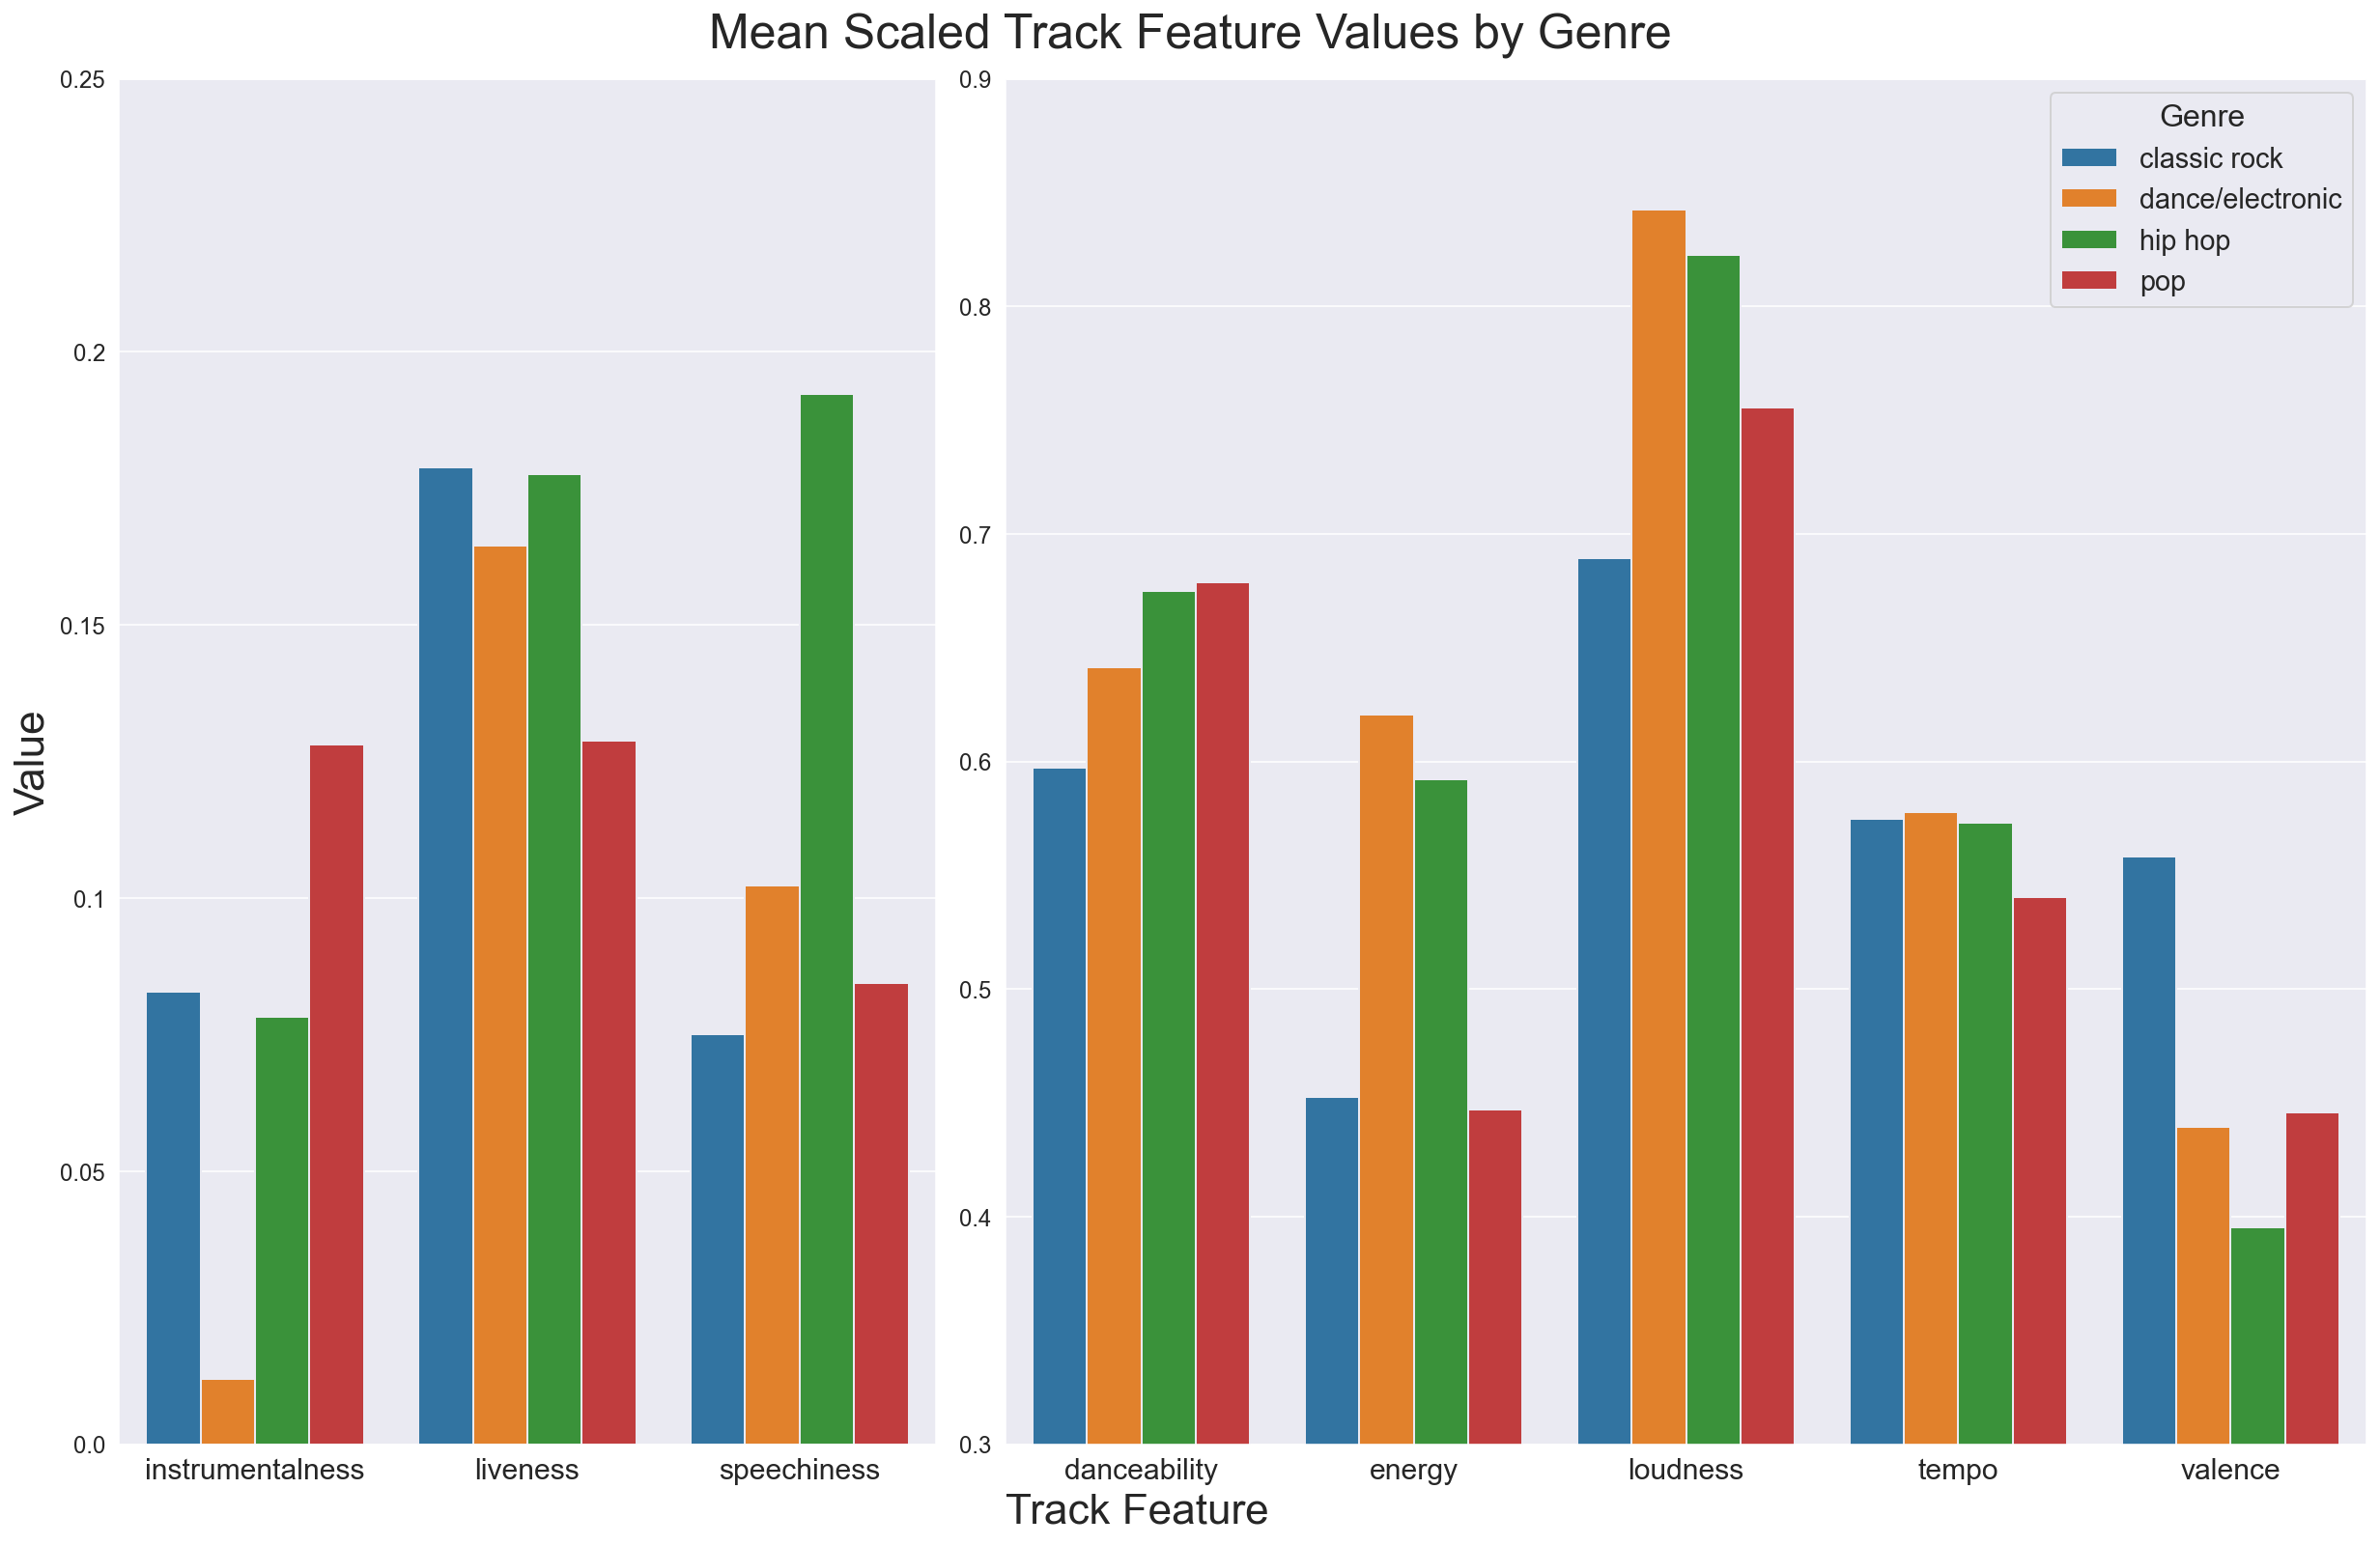

In [22]:
# Melt dataframe to make compatible with Seaborn barplot
melted_df = pd.melt(feature_avgs_by_genre.reset_index(), id_vars='genre', var_name='track_feature')

# Define features to plot on left subplot (smaller scale)
ax1_features = ['instrumentalness', 'liveness', 'speechiness']
ax1_df = melted_df.loc[melted_df.track_feature.isin(ax1_features)]

# Define features to plot on right subplot (larger scale)
ax2_features = ['danceability', 'energy', 'loudness', 'tempo', 'valence']
ax2_df = melted_df.loc[melted_df.track_feature.isin(ax2_features)]

# Define figure and axes - set proportional width ratios
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 11), constrained_layout=True, 
                               gridspec_kw={'width_ratios': [(3/8), (5/8)]})

# Plot left subplot
sns.barplot(x='track_feature', y='value', hue='genre', data=ax1_df, edgecolor='#EAEAF2', ax=ax1)

# Plot right subplot
sns.barplot(x='track_feature', y='value', hue='genre', data=ax2_df, edgecolor='#EAEAF2', ax=ax2)

fig.suptitle('Mean Scaled Track Feature Values by Genre', fontsize=25)

# Set shared x-axis label
ax1.set_xlabel('')
ax2.set_xlabel('Track Feature', fontsize=22, loc='left')

# Set shared y-axis label
ax1.set_ylabel('Value', fontsize=22)
ax2.set_ylabel('')

# Set appropriate y-tick ranges; start right subplot at 0.3
ax1.set_yticks(np.arange(0, 0.3, 0.05))
ax2.set_yticks(np.arange(0.3, 0.9, 0.1))
ax2.set_ylim(bottom=0.3);

ax1.set_yticklabels([round(n, 2) for n in np.arange(0, 0.3, 0.05)], size=12);
ax2.set_yticklabels([round(n, 1) for n in np.arange(0.3, 0.9, 0.1)], size=12);

# Increase x-axis label fontsizes
for ax in [ax1, ax2]: ax.set_xticklabels(ax.get_xticklabels(), size=15)

# Set shared legend
ax1.get_legend().remove()
ax2.legend(title='Genre', title_fontsize=16, fontsize='x-large');

# Save
if not os.path.exists('visualizations/1_mean_track_feature_vals_by_genre'):
    plt.savefig('visualizations/1_mean_track_feature_vals_by_genre.png', facecolor='white', 
                transparent=False, dpi=400)

**Insights:**
- Pop is by far the most instrumental genre, and dance/electronic is by far the least.
- Liveness is generally consistent across genres, but pop tends to be a bit less lively than the others.
- Hip hop is by far the most "speechy" genre. The other genres are relatively consistent in speechiness.
- Surprisingly, dance/electronic is the second least danceable genre, though danceability is relatively consistent across genres. Pop is the most danceable.
- Dance/electronic and hip hop stand out as the genres with highest energy.
- Classic rock is the least loud while dance/electronic is the loudest, but differences are modest.
- Tempo is remarkably consistent across genres, though pop has a bit lower tempo than the others.
- Classic rock has by far the highest valence, while hip hop tends to have the lowest.

<br>

### 2.2: Distribution of `track_feature` and `duration_ms` values

In [23]:
# Create new dataframe for visualization by adding duration_ms column to viz1_df (which contains track features)
viz2_df = viz1_df.merge(tracks_df[['track_id', 'duration_ms']], on='track_id')

# Drop irrelevant columns
viz2_df = viz2_df.drop(columns=['track_id', 'genre'])

# Convert duration column from milliseconds to minutes, for readability
viz2_df['duration_ms'] = viz2_df['duration_ms'].map(lambda x: x / 1000 / 60)
viz2_df = viz2_df.rename(columns={'duration_ms': 'duration_mins'})

viz2_df.head()

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_mins
0,0.554,0.535,0.000013,0.1240,-8.959,0.1860,105.865,0.136,3.466900
1,0.556,0.630,0.004680,0.1550,-8.150,0.1020,149.147,0.367,3.506200
2,0.545,0.641,0.000066,0.1710,-6.398,0.0998,121.892,0.464,3.590983
3,0.780,0.689,0.000010,0.0698,-5.668,0.1410,115.042,0.642,3.756467
4,0.903,0.519,0.000106,0.1550,-9.151,0.2600,114.991,0.587,1.945450


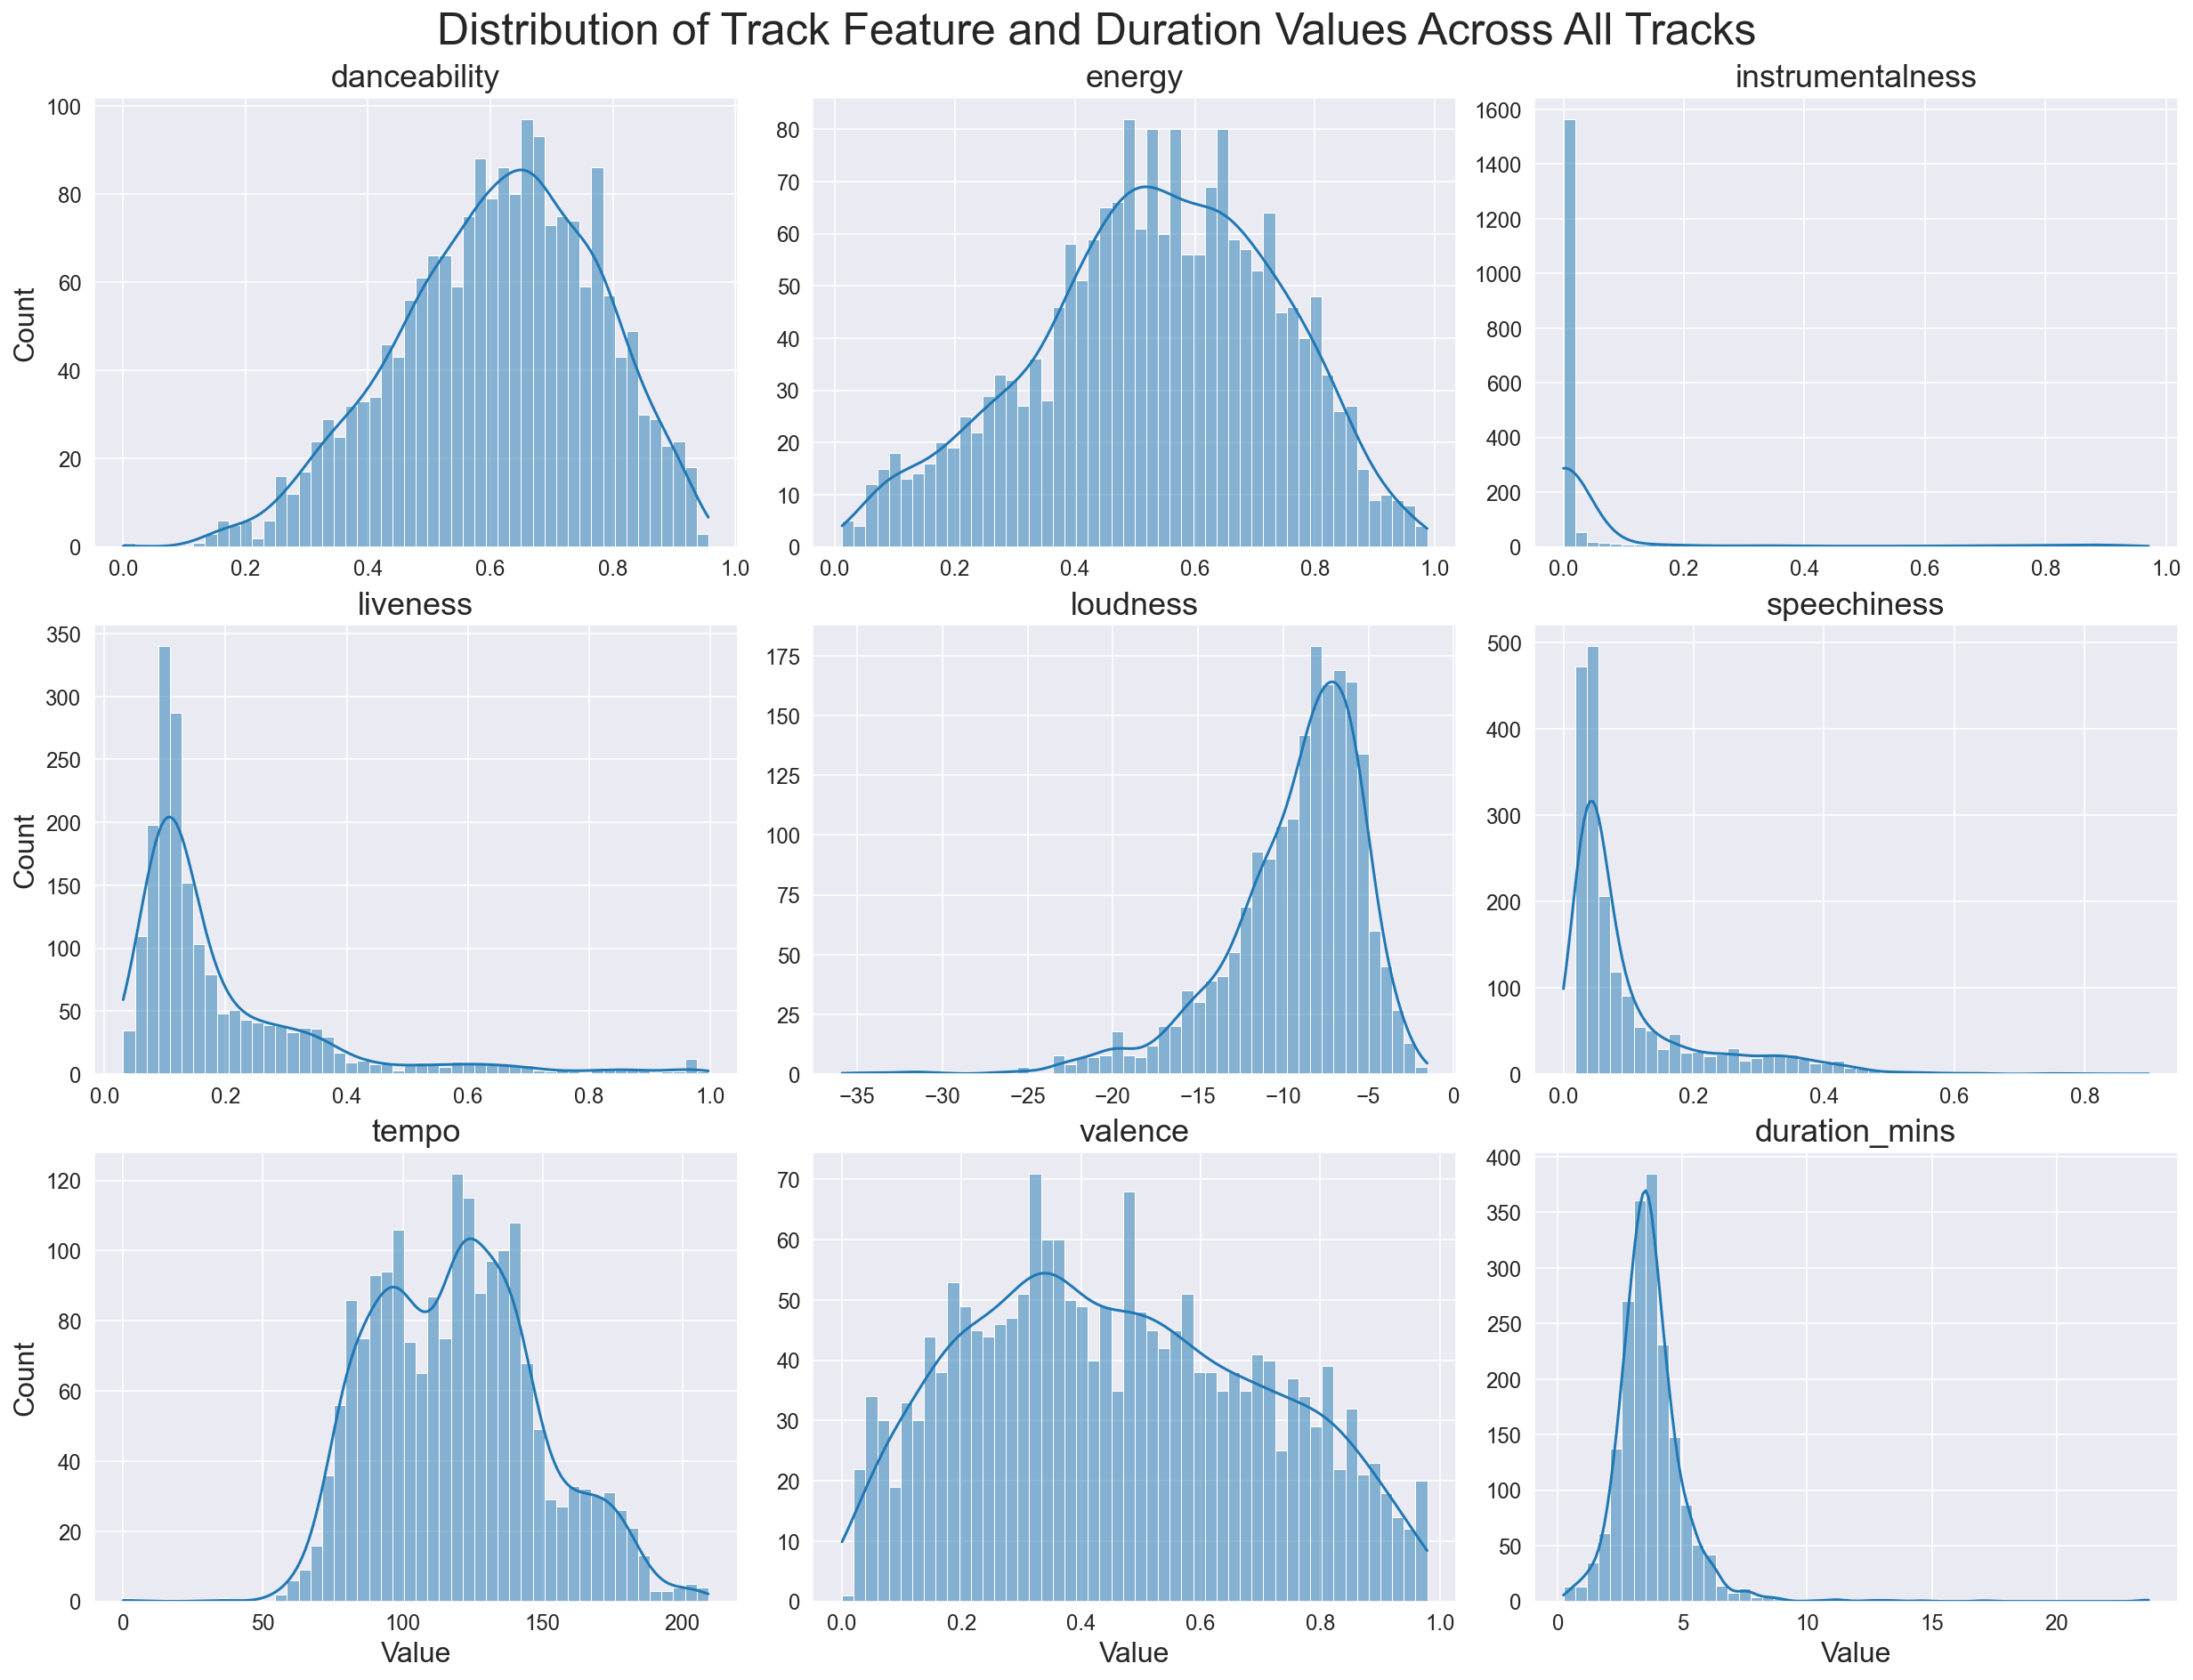

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 13), constrained_layout=True)

# Create list of columns to plot, for loop below
numericals = [column for column in viz2_df.columns]

fig.suptitle('Distribution of Track Feature and Duration Values Across All Tracks', fontsize=25)

for n, (feature, ax) in enumerate(zip(numericals, axes.flatten())):
    # Plot histogram for each track feature, plus duration_mins
    sns.histplot(viz2_df[feature], bins=50, ax=ax, kde=True)
    ax.set_title(feature, fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    # Display y-axis label on left-column histograms only
    if n % 3 == 0:
        ax.set_ylabel('Count', fontsize=16)
    else:
        ax.set_ylabel('')
    # Display x-axis label on bottom-row histograms only
    if n > 5:
        ax.set_xlabel('Value', fontsize=16)
    else:
        ax.set_xlabel('')
        
# Save
if not os.path.exists('visualizations/2_track_feature_distributions'):
    plt.savefig('visualizations/2_track_feature_distributions.png', facecolor='white', transparent=False, dpi=400)

**Insights:**
- Danceability, energy, tempo, valence, and duration are quite normally distributed, with median danceability of around 0.65, median energy of around 0.5, median tempo of around 110, and median duration of around 3.5 minutes.
- Instrumentalness is extremely right-skewed, with nearly all values being near 0. Liveness is right-skewed with a peak around 0.1 and loudness is left-skewed with a peak around -7. Speechiness is also highly right-skewed, with a peak around 0.05.

<br>

### 2.3: Evolution of artists, visualized

In [25]:
# Create new dataframe for visualization by adding artist_name to scaled track features df from first viz
viz3_df = viz1_df_scaled.merge(tracks_df[['track_id', 'album_id']], on='track_id').drop(columns='genre')
viz3_df = viz3_df.merge(albums_df[['album_id', 'artist_id', 'release_date']], on='album_id')
viz3_df = viz3_df.merge(artists_df[['artist_id', 'artist_name']], on='artist_id')

# Only keep release year of release_date column
viz3_df['release_date'] = viz3_df.release_date.dt.strftime('%Y')

# Drop irrelevant columns
viz3_df = viz3_df.drop(columns=['track_id', 'album_id', 'artist_id'])

# Preview viz3_df
display(viz3_df.head())

# Group viz3_df by artist_name and release_date and get mean values for each track feature, and preview dataframe
feature_artist_evolution = viz3_df.groupby(['artist_name', 'release_date']).mean()
display(feature_artist_evolution.head())

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,release_date,artist_name
0,0.579498,0.536505,0.000014,0.096367,0.784342,0.207127,0.505945,0.138917,2022,Beyoncé
1,0.581590,0.633921,0.004820,0.128455,0.807896,0.113586,0.712797,0.374872,2022,Beyoncé
2,0.570084,0.645201,0.000068,0.145016,0.858906,0.111136,0.582541,0.473953,2022,Beyoncé
3,0.815900,0.694422,0.000010,0.040265,0.880161,0.157016,0.549804,0.655771,2022,Beyoncé
4,0.944561,0.520098,0.000109,0.128455,0.778752,0.289532,0.549560,0.599591,2022,Beyoncé


danceability    energy  instrumentalness  liveness  \
artist_name release_date                                                       
Beyoncé     2007              0.647671  0.707485          0.000394  0.150178   
            2008              0.532617  0.551794          0.003988  0.154774   
            2011              0.632098  0.707166          0.000457  0.183462   
            2014              0.588598  0.555527          0.005527  0.246672   
            2016              0.558980  0.486259          0.061067  0.234058   

                          loudness  speechiness     tempo   valence  
artist_name release_date                                             
Beyoncé     2007          0.890182     0.200479  0.599261  0.512502  
            2008          0.814998     0.121664  0.513614  0.448138  
            2011          0.872809     0.133980  0.592489  0.537429  
            2014          0.796997     0.154376  0.581799  0.382416  
            2016          0.763220     0.159457  0.593423  0.407590

Which artist/band would you like to visualize? The Beatles


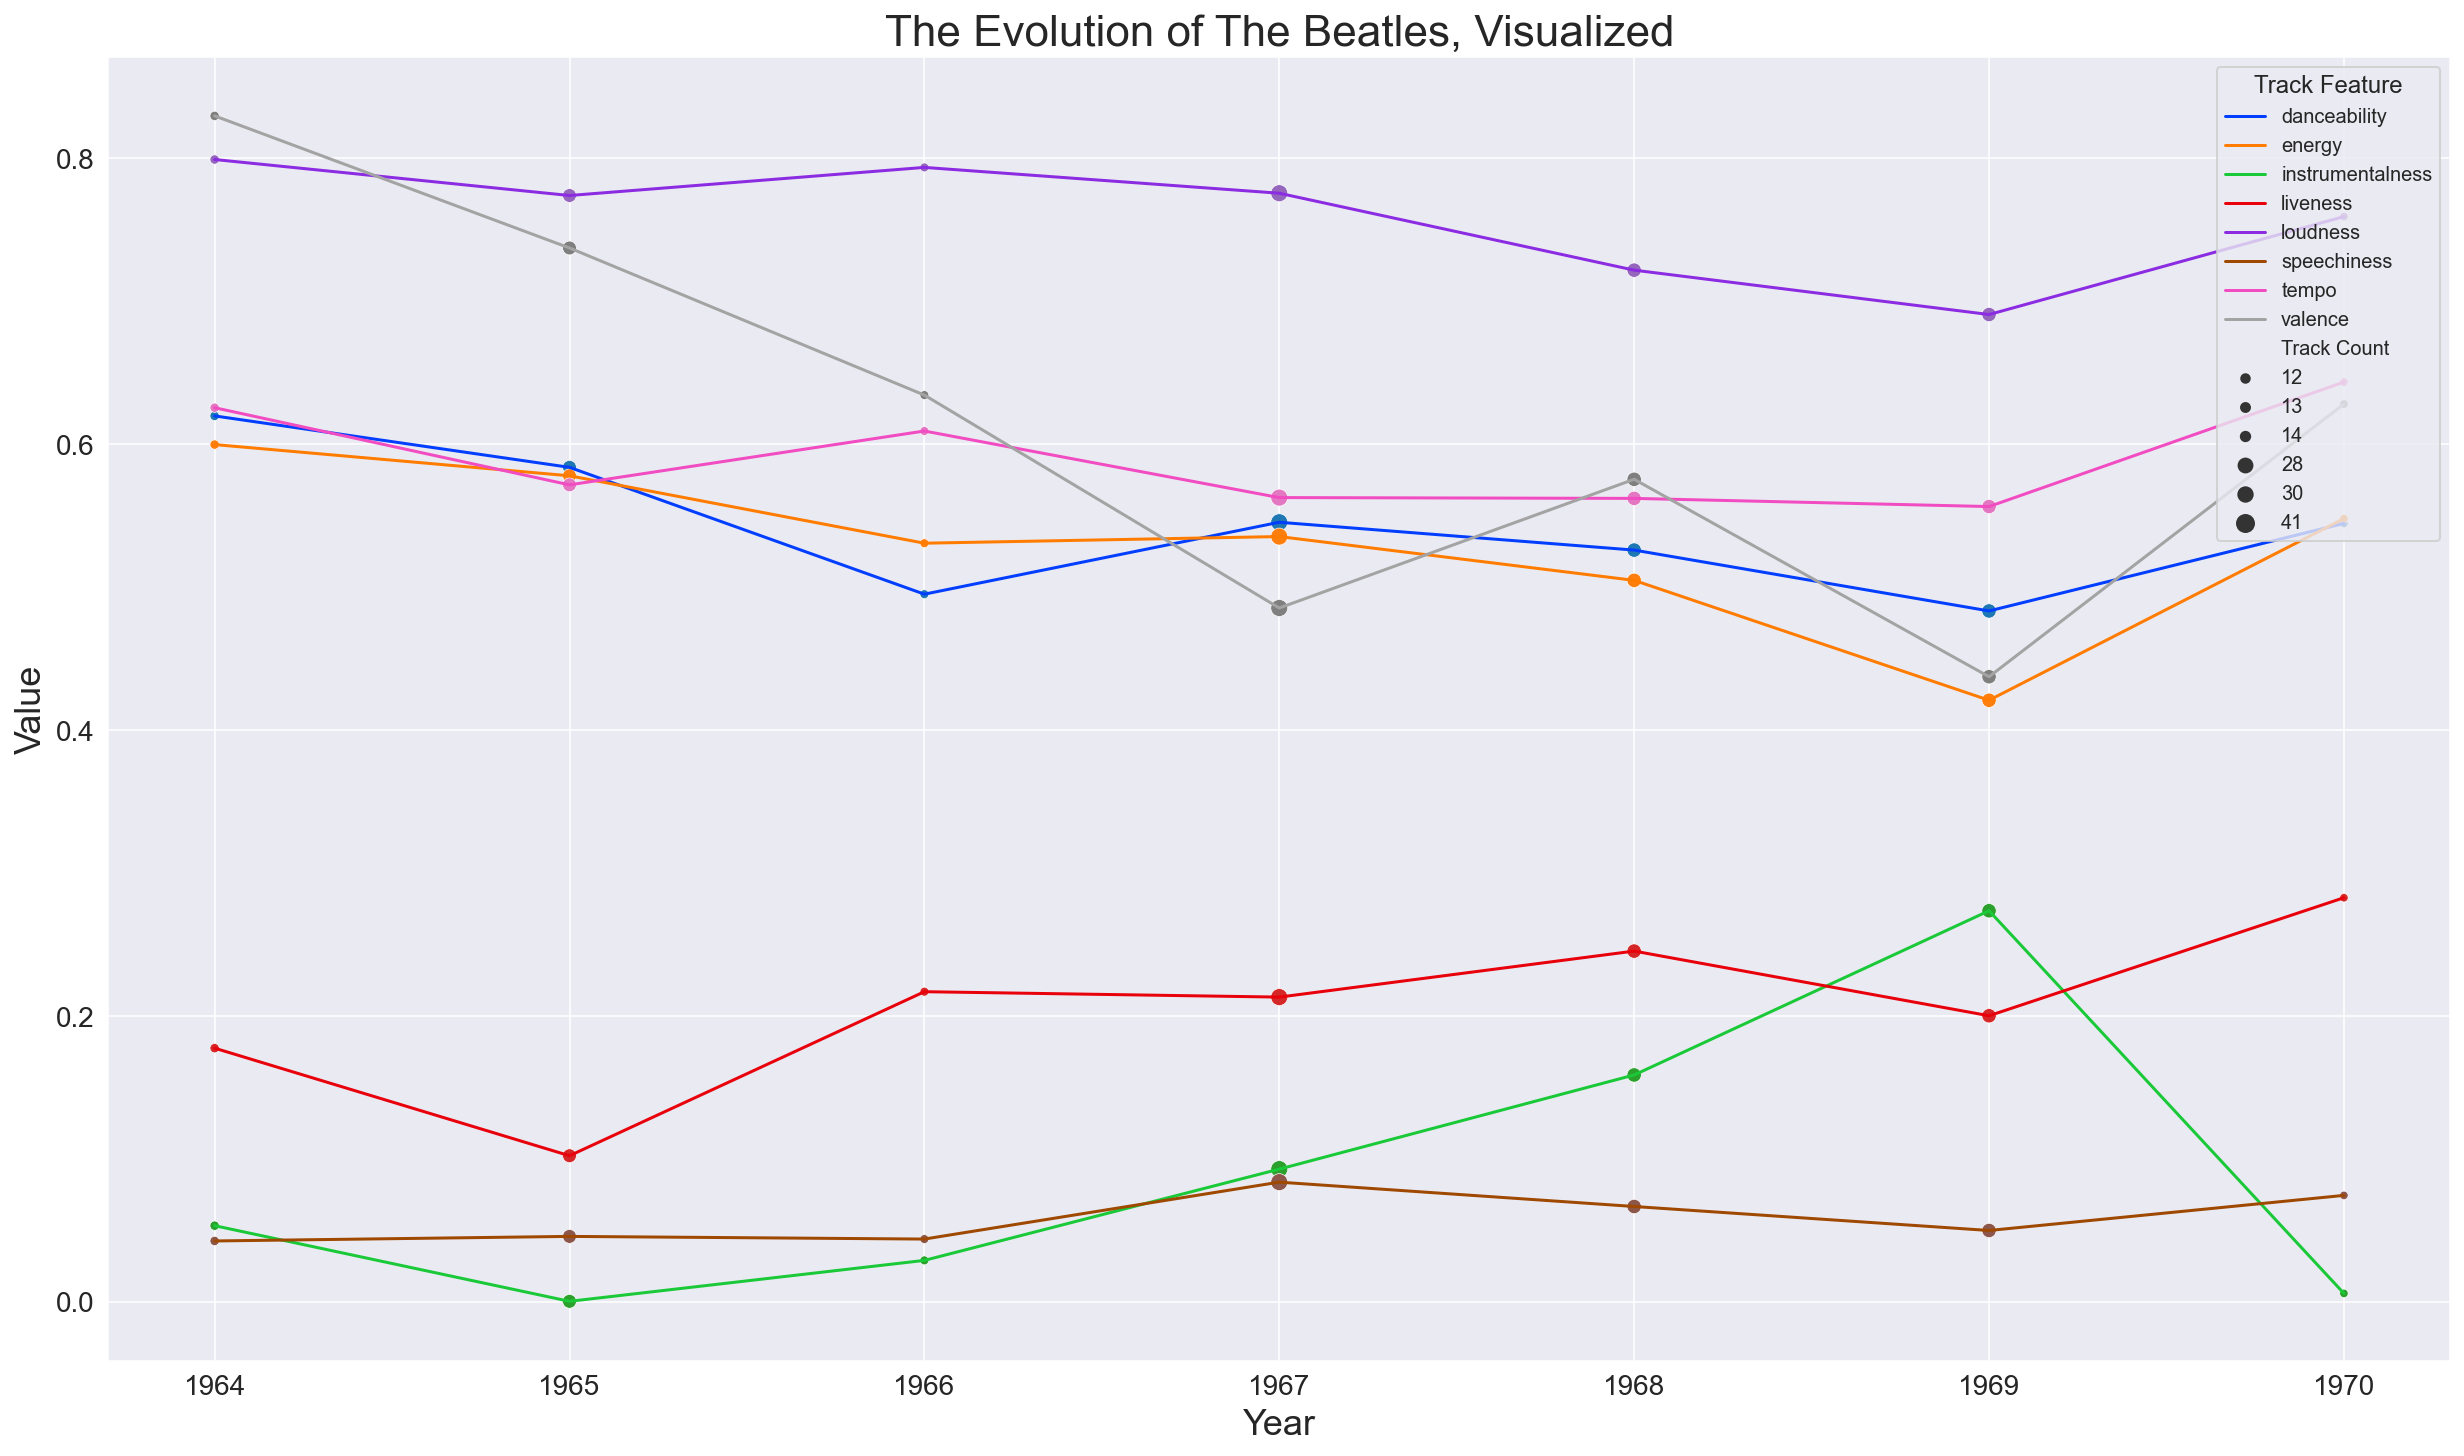

In [26]:
# Melt dataframe to make compatible with Seaborn lineplot
melted_df = pd.melt(feature_artist_evolution.reset_index(), id_vars=['artist_name', 'release_date'], 
                    var_name='track_feature', value_name='mean_value')

# Add column of count of tracks per row to melted_df
track_counts = viz3_df.groupby(['artist_name', 'release_date']).count()
track_counts = pd.melt(track_counts.reset_index(), id_vars=['artist_name', 'release_date'], 
                       var_name='track_feature', value_name='Track Count')
melted_df = melted_df.merge(track_counts, on=['artist_name', 'release_date', 'track_feature'])

# Choose artist to visualize
artist = input('Which artist/band would you like to visualize? ')
if artist != 'blackbear': artist = artist.title()
artist_data = melted_df[melted_df.artist_name == artist]

# Print message below if artist not in database
if not artist in artist_data.artist_name.unique():
    print("\nSorry, that artist isn't in our database!")
    
else:
    fig, ax = plt.subplots(figsize=(17, 10), constrained_layout=True)
    # Plot change in track_feature values as lines
    sns.lineplot(x='release_date', y='mean_value', hue='track_feature', data=artist_data, palette='bright')
    # Plot number of tracks per year as scatterplot circles
    sns.scatterplot(x='release_date', y='mean_value', hue='track_feature', data=artist_data, 
                    size='Track Count', legend=True)
    ax.set_title('The Evolution of ' + artist + ', Visualized', fontsize=22)
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('Value', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # Remove scatterplot track_feature portion of legend (duplicative)
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[:8]+h[-7:], l[:8]+l[-7:], title='Track Feature', title_fontsize=12, fontsize='medium', loc=1);
    
# Save
if not os.path.exists('visualizations/3_artist_evolution'):
    plt.savefig('visualizations/3_artist_evolution.png', facecolor='white', transparent=False, dpi=400)

<br>

### 2.4: Evolution of genres, visualized

In [27]:
# Create new dataframe for visualization by adding artist_name to scaled track features df from first viz
viz4_df = viz1_df_scaled.merge(tracks_df[['track_id', 'album_id']], on='track_id')
viz4_df = viz4_df.merge(albums_df[['album_id', 'artist_id', 'release_date']], on='album_id')
viz4_df = viz4_df.merge(artists_df[['artist_id', 'artist_name']], on='artist_id')

# Only keep release year of release_date column
viz4_df['release_date'] = viz4_df.release_date.dt.strftime('%Y')

# Drop irrelevant columns
viz4_df = viz4_df.drop(columns=['track_id', 'album_id', 'artist_id'])
display(viz4_df.head())

# Group viz3_df by artist_name and release_date and get mean values for each track feature, and preview dataframe
feature_genre_evolution = viz4_df.groupby(['genre', 'release_date']).mean()
display(feature_genre_evolution.head())

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre,release_date,artist_name
0,0.579498,0.536505,0.000014,0.096367,0.784342,0.207127,0.505945,0.138917,dance/electronic,2022,Beyoncé
1,0.581590,0.633921,0.004820,0.128455,0.807896,0.113586,0.712797,0.374872,dance/electronic,2022,Beyoncé
2,0.570084,0.645201,0.000068,0.145016,0.858906,0.111136,0.582541,0.473953,dance/electronic,2022,Beyoncé
3,0.815900,0.694422,0.000010,0.040265,0.880161,0.157016,0.549804,0.655771,dance/electronic,2022,Beyoncé
4,0.944561,0.520098,0.000109,0.128455,0.778752,0.289532,0.549560,0.599591,dance/electronic,2022,Beyoncé


danceability    energy  instrumentalness  liveness  \
genre        release_date                                                       
classic rock 1964              0.534559  0.438967          0.035924  0.150371   
             1965              0.583570  0.577669          0.000210  0.102049   
             1966              0.479719  0.456636          0.036532  0.151195   
             1967              0.545158  0.535155          0.092683  0.213011   
             1968              0.509713  0.442227          0.136630  0.232646   

                           loudness  speechiness     tempo   valence  
genre        release_date                                             
classic rock 1964          0.709607     0.039545  0.612648  0.700479  
             1965          0.773714     0.045625  0.571328  0.737013  
             1966          0.715140     0.044720  0.552247  0.581132  
             1967          0.775307     0.083579  0.562419  0.485184  
             1968          0.657394     0.081721  0.563943  0.559195

Which genre would you like to visualize? Hip Hop


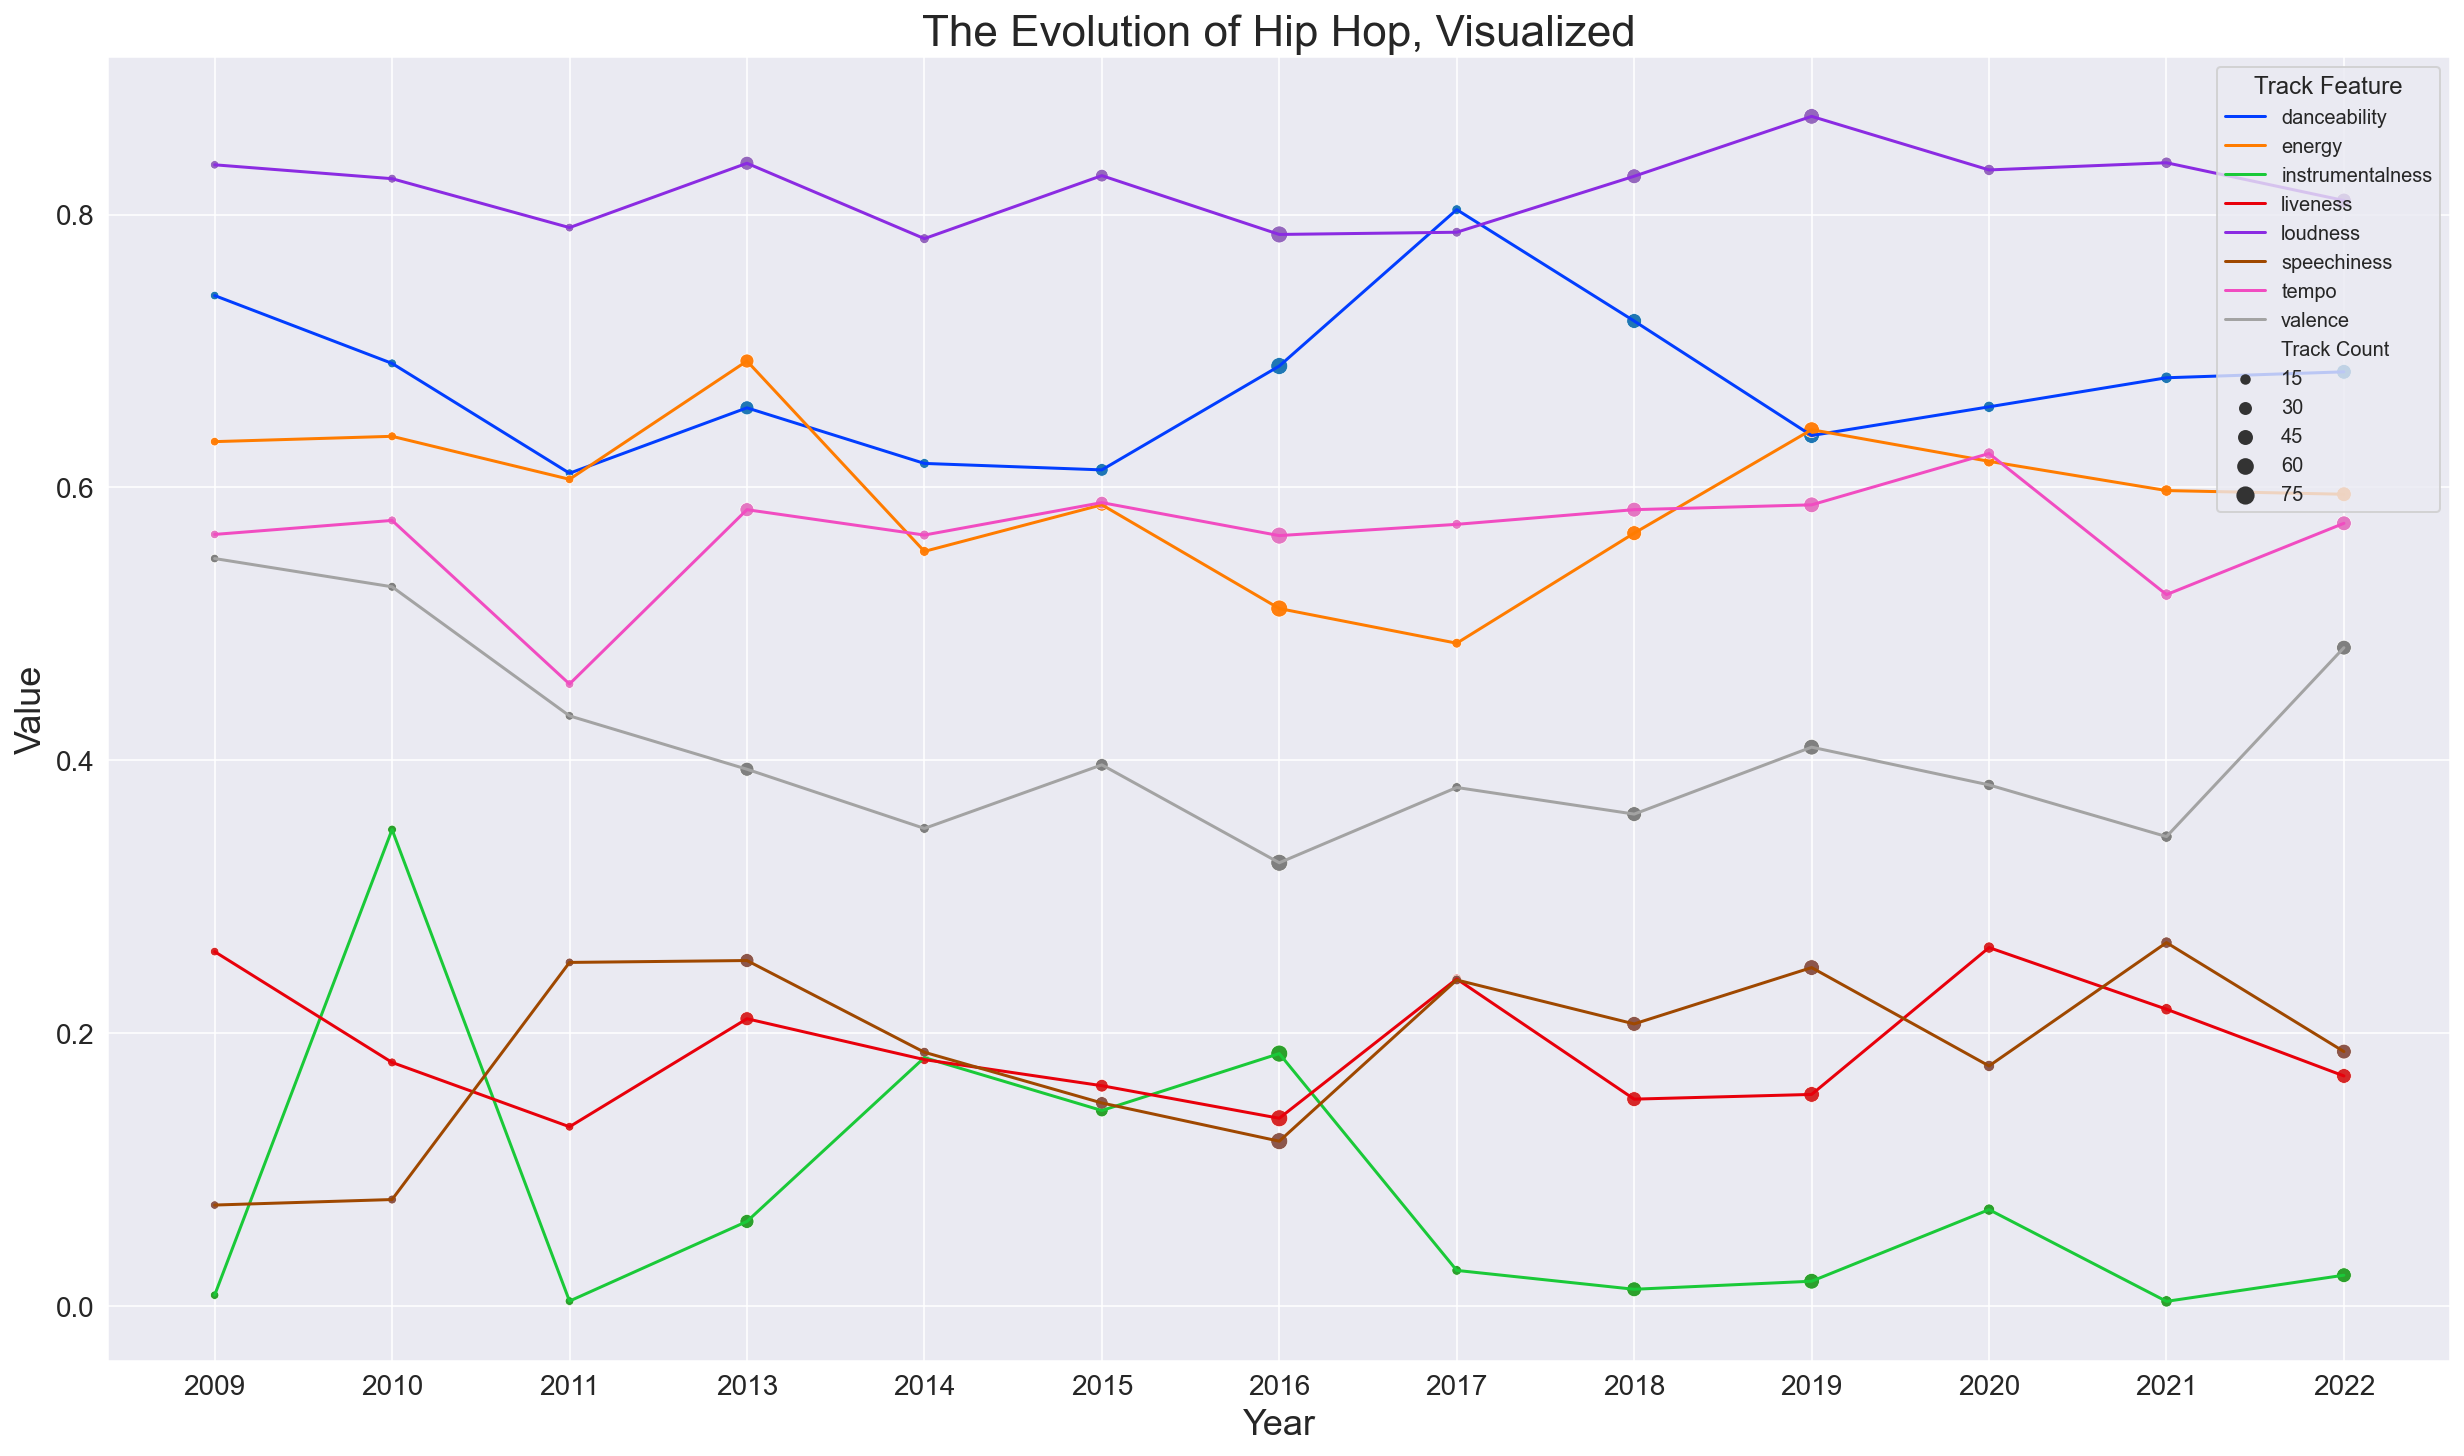

In [28]:
# Melt dataframe to make compatible with Seaborn lineplot
melted_df = pd.melt(feature_genre_evolution.reset_index(), id_vars=['genre', 'release_date'], 
                    var_name='track_feature', value_name='mean_value')

# Add column of count of tracks per row to melted_df
track_counts = viz4_df.drop(columns='artist_name').groupby(['genre', 'release_date']).count()
track_counts = pd.melt(track_counts.reset_index(), id_vars=['genre', 'release_date'], 
                       var_name='track_feature', value_name='Track Count')
melted_df = melted_df.merge(track_counts, on=['genre', 'release_date', 'track_feature'])

# Choose artist to visualize
genre = input('Which genre would you like to visualize? ')
genre = genre.lower()
genre_data = melted_df[melted_df.genre == genre]

# Print message below if artist not in database
if not genre in genre_data.genre.unique():
    print("\nSorry, that genre isn't in our database!")
else:
    fig, ax = plt.subplots(figsize=(17, 10), constrained_layout=True)
    # Plot change in track_feature values as lines
    sns.lineplot(x='release_date', y='mean_value', hue='track_feature', data=genre_data, palette='bright')
    # Plot number of tracks per year as scatterplot circles
    sns.scatterplot(x='release_date', y='mean_value', hue='track_feature', data=genre_data, 
                    size='Track Count', legend=True)
    ax.set_title('The Evolution of ' + genre.title() + ', Visualized', fontsize=22)
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('Value', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # Remove scatterplot track_feature portion of legend (duplicative)
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[:8]+h[-6:], l[:8]+l[-6:], title='Track Feature', title_fontsize=12, fontsize='medium', loc=1);
    
# Save
if not os.path.exists('visualizations/4_genre_evolution'):
    plt.savefig('visualizations/4_genre_evolution.png', facecolor='white', transparent=False, dpi=400)

<br>

### 2.5: Correlations between `track_feature` values + `duration_ms` + `followers`

In [29]:
# Create new dataframe of unscaled track features, duration_ms, and followers
viz5_df = track_features_df.merge(tracks_df[['track_id', 'album_id', 'duration_ms']], on='track_id')
viz5_df = viz5_df.merge(albums_df[['album_id', 'artist_id']], on='album_id')
viz5_df = viz5_df.merge(artists_df[['artist_id', 'followers']], on='artist_id')
# Drop irrelevant columns
viz5_df = viz5_df.drop(columns=['track_id', 'album_id', 'artist_id', 'type', 'song_uri'])

viz5_df.head()

,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,followers
0,0.554,0.535,0.000013,0.1240,-8.959,0.1860,105.865,0.136,208014,32184686
1,0.556,0.630,0.004680,0.1550,-8.150,0.1020,149.147,0.367,210372,32184686
2,0.545,0.641,0.000066,0.1710,-6.398,0.0998,121.892,0.464,215459,32184686
3,0.780,0.689,0.000010,0.0698,-5.668,0.1410,115.042,0.642,225388,32184686
4,0.903,0.519,0.000106,0.1550,-9.151,0.2600,114.991,0.587,116727,32184686


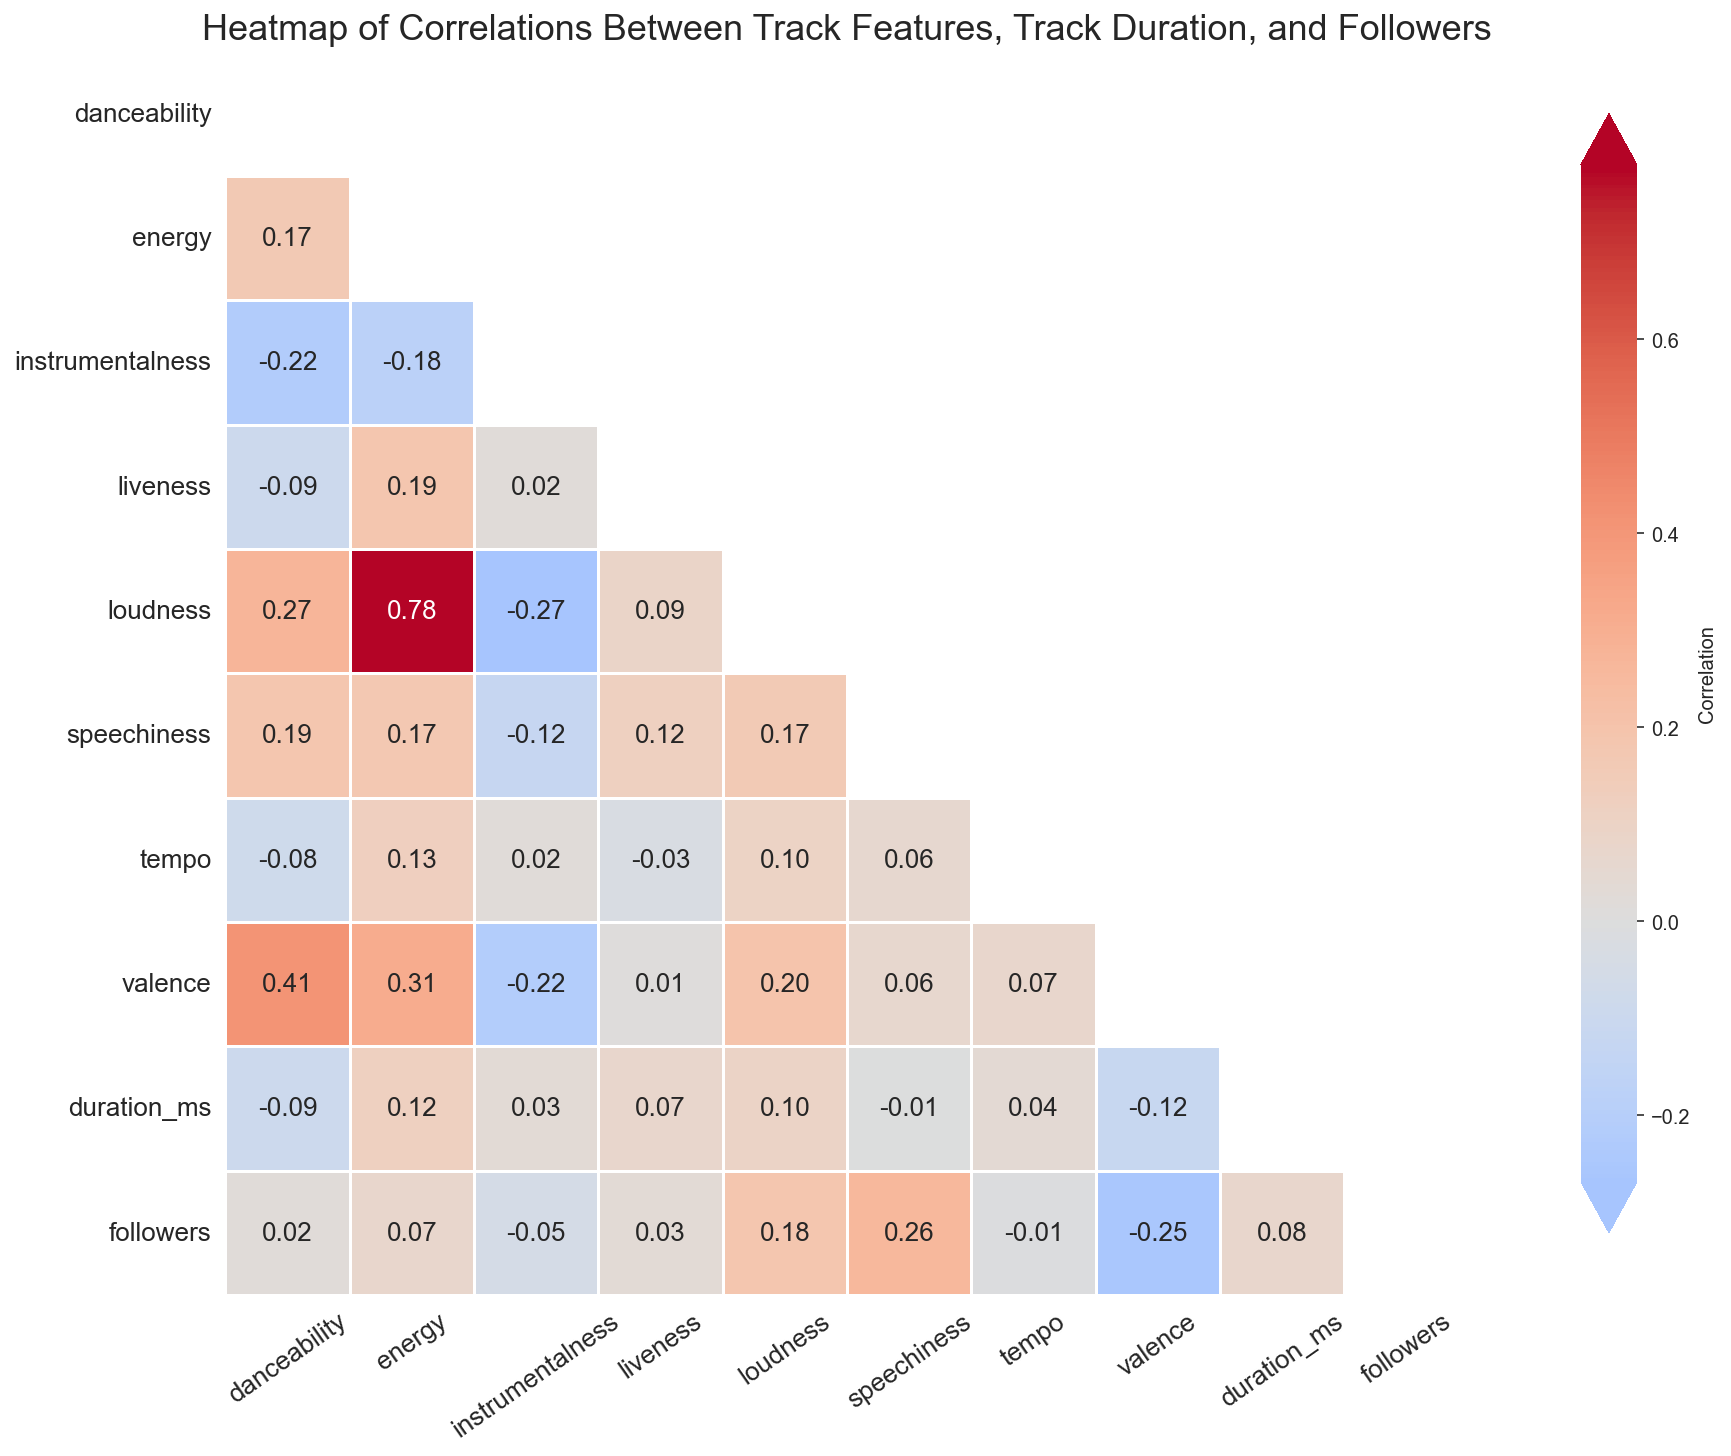

In [30]:
# Create correlation table between attributes
corr = viz5_df.corr()

# Mask duplicate correlations and self-correlations
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(13, 10), constrained_layout=True)

sns.heatmap(data=corr, annot=True, cmap='coolwarm', mask=mask, square=True, center=0.0, linewidths=.6, fmt='.2f', 
            annot_kws={'fontsize': 13}, cbar_kws={'label': 'Correlation', 'orientation': 'vertical', 
                                                  'pad': .07, 'extend': 'both', 'shrink': .9})
ax.set_facecolor('xkcd:white')
ax.set_title('Heatmap of Correlations Between Track Features, Track Duration, and Followers', fontsize=18)
ax.tick_params(axis='x', which='major', rotation=35, labelsize=13)
ax.tick_params(axis='y', which='major', rotation=0, labelsize=13);

# Save
if not os.path.exists('visualizations/5_correlation_heatmap'):
    plt.savefig('visualizations/5_correlation_heatmap.png', facecolor='white', transparent=False, dpi=400)

**Insights:**
- The correlation with highest absolute value in the heatmap is between loudness and energy at 0.78. This makes sense, given that very loud songs tend to be high-energy. In fact, I wouldn't be surprised if loudness is one of the metrics Spotify uses in their track "energy" algorithm. Valence is also correlated with energy to a relatively high degree.
- Other notable correlations include valence and danceability at 0.41 – also logical given that danceable songs tend to be happy and high-valence. However, something to note is that hip hop was nearly tied as the most danceable genre, but it had by far the lowest valence, so that is potentially something that warrants further analysis.
- Among negative correlations, instrumentalness and loudness are at -0.27, and instrumentalness and valence are at -0.22.
- The track feature most correlated with more followers is speechiness at 0.26, while the least correlated feature is valence at -0.25. However, this may be more noise than signal, as we saw that hip hop tends to have high speechiness and most of the hip hop artists I chose are megastars with tons of followers. Obtaining more data could potentially resolve whether this correlation is an artifact of my dataset or whether we really do tend to prefer "speechy" music on the whole. This is also something that warrants further analysis.